# Supervised learning- regression- knn and penalisation

We work further on the same dataset as last labo: the housing dataset. The first steps (looking at the data, test/train-split and standardisation are already done for you in the code below.

## 0. Loading packages and dataset

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

df = pd.read_csv('real_estate_cleaned.csv')

C:\Users\tomas\AppData\Local\Temp\ipykernel_24248\2606113159.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# 1. Take a look at the data

Explore the data, as usual.
1. Look at the dimensions of the dataset
2. Look at the first lines of the dataset
3. Get an overview of the features and their datatype
4. Convert the dummy features to uint8

In [3]:
# dimensions
df.shape # (number of rows, number of columns)

(803, 39)

In [4]:
# look at the first few lines of dataset
df.head() 

,tx_price,beds,baths,sqft,year_built,lot_size,restaurants,groceries,nightlife,cafes,...,exterior_walls_Siding (Alum/Vinyl),exterior_walls_Wood,roof_Asphalt,roof_Composition,roof_Gravel/rock,roof_Missing,roof_Other,roof_Shake shingle,basement_1.0,basement_Missing
0,12.597611,1,1,6.371612,2013,8.388054,4.682131,2.302585,3.433987,2.995732,...,0,1,0,0,0,1,0,0,0,1
1,12.285350,1,1,6.418365,1965,8.388054,4.663439,2.772589,1.945910,2.639057,...,0,0,0,1,0,0,0,0,1,0
2,12.542191,1,1,6.423247,1963,8.388054,5.214936,2.639057,3.465736,3.433987,...,0,1,0,0,0,1,0,0,0,1
3,12.847666,1,1,6.428105,2000,10.420554,5.293305,2.302585,3.663562,3.258097,...,0,1,0,0,0,1,0,0,0,1
4,12.736704,1,1,6.453625,1992,8.388054,5.010635,2.079442,3.135494,3.044522,...,0,0,0,0,0,1,0,0,0,1


In [5]:
# Get an overview of the features and their datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   tx_price                            803 non-null    float64
 1   beds                                803 non-null    int64  
 2   baths                               803 non-null    int64  
 3   sqft                                803 non-null    float64
 4   year_built                          803 non-null    int64  
 5   lot_size                            803 non-null    float64
 6   restaurants                         803 non-null    float64
 7   groceries                           803 non-null    float64
 8   nightlife                           803 non-null    float64
 9   cafes                               803 non-null    float64
 10  shopping                            803 non-null    float64
 11  arts_entertainment                  803 non-n

In [6]:
# Convert the dummy features to type uint8
df.iloc[:,25:39] = df.iloc[:,25:39].astype('uint8')

C:\Users\tomas\AppData\Local\Temp\ipykernel_24248\471231482.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:,25:39] = df.iloc[:,25:39].astype('uint8')


# 2 Train/test-split and standardisation

1. Shuffle your data

2. Make a Train/test 
    - Use random state=123 whenever needed
    - Use a test size of 20%
    
3. Standardize both datasets  
    + Make sure you only standardise the numerical features

1. Shuffle

In [9]:
#shuffle the data
from random import Random
df_shuffle = df.sample(frac=1, random_state=Random().randint(0,1000))

2. Split

In [10]:
#split the data into train and test
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(['tx_price'],1)
y = df_shuffle['tx_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\tomas\AppData\Local\Temp\ipykernel_24248\652876445.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['tx_price'],1)


3. Standardize

In [14]:
# standardise
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64','float64']).columns

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train_stan = X_train.copy()
X_test_stan = X_test.copy()
X_train_stan[num_feat] = scaler.transform(X_train[num_feat])
X_test_stan[num_feat] = scaler.transform(X_test[num_feat])

# 3. Nearest neighbors
## 3.1. Radius Neighbors Regression

1. Perform a crossvalidation, using radius neighbors regression, with the radius ranging from 1 to 10
    + Does it work?
    + Why (not)?
2. Search for the minimum radius that does work and do a crossvalidation with 10 values. 
    + E.g if it works at radius 5, let the radius range from 5 to 15.
    + Draw a plot that plots the radius against the R2
    + Is your best model a good model: is it underfitted or overfitted?
    + Is RNN a good method to use when there are a lot of features.

1. Crossvalidation from 1 to 10.

In [16]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import cross_val_score

Radius = np.linspace(1,10,10)    # This will give an array of numbers between 1 and 10
cv_scores = []
sd_scores = []

# perform 5-fold cross validation on the 10 possible values for the radius (bandwith)
for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius=k)
    scores = cross_val_score(Rnn, X_train_stan, y_train,  cv=5)
    # store the average score
    cv_scores.append(scores.mean())
    # store the standard deviation of the score
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\metrics\_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\base.

2. Crossvalidation that works.

In [17]:
# cross-validation
Radius = np.linspace(1,10,10)    # This will give an array of numbers between 1 and 10   
cv_scores = [] # store the average score
sd_scores = [] # store the standard deviation of the score

for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius=k)
    scores = cross_val_score(Rnn, X_train_stan, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 

c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\metrics\_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\base.

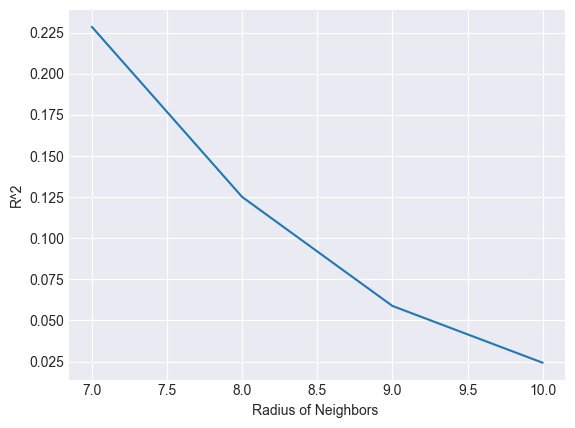

In [21]:
# plot

## First determine the maximum value and its index  
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

# Plit the radius versus the cv_scores
plt.plot(Radius, cv_scores)
plt.xlabel('Radius of Neighbors ')
plt.ylabel('R^2')

# plot the lower limit (max - 1.96 * sd.dev)
plt.axhline(y=max_value - 1.96 * sd_scores[max_index])

plt.show()


## 3.2 K-nearest Neighbors
1. Perform a crossvalidation, using k-nearest neighbors regression, with k ranging from 1 to 65
    
2. Plot the number of neighbors (k) to the R2
    + Also draw the lower boundary of the confidene interval of the maximum R2(maximum R2 - 1.96 * sd(of maximum R2) )
    + First do a general plot
    + Then zoom in on the highest values 
    + Which k leads to the highest R2



1. Cross-validation

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,65)    
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for k in K:
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X_train_stan, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

2. plots

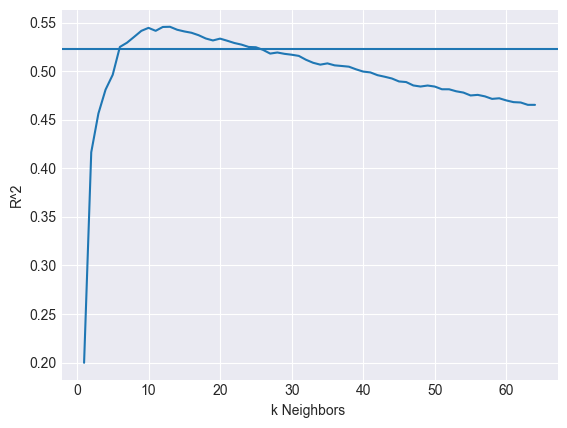

The best k is 13


In [27]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')
plt.axhline(y=max_value - 1.96 * sd_scores[max_index])

plt.show()
print('The best k is', K[max_index])

This plot is hard to read, so lets zoom in.

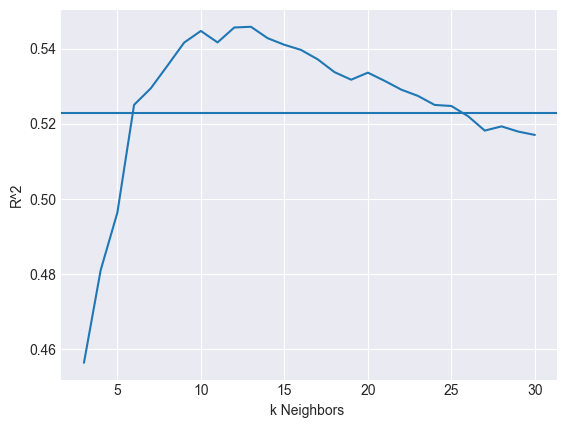

The best k is 13
the best validation score is 0.5457884082323405


In [29]:
#Zoom in on the plot
plt.plot(K[2 : 30],cv_scores[2 : 30])
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.axhline(y=max_value - 1.96 * sd_scores[max_index])


plt.show()
# print the best k
print('The best k is', K[max_index])
# print the best validation score
print('the best validation score is', max_value)

3. Retrain and test


In [31]:
# Retrain on full training dataset and test on test-set

knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stan, y_train)
print('train value for k=5:', knn.score(X_train_stan, y_train) )
print('test value for k=5:', knn.score(X_test_stan, y_test) )

train value for k=5: 0.6203805635656502
test value for k=5: 0.5537944841906065


# 4. Penalisation

Untill know, we have seen that polynomial regression  leads to overfitting and knn leads to underfitting on this dataset, because of the curse of high dimensionality. Now, we will try a different approach, namely combining polynomial regression with penalisation.

1. Design polynomial features with degree 3
    + Don't forget to also transform the test data
    + Check the number of features of the new datasets: are there more observations or more features?
2. Do lasso-penalisation, using the default alpha. 
    + Use linear_model.Lasso()
    + Test on train and test set
    + Is the model overfitted or underfitted?   
    + Look at the coefficients. Does this explain the overfitting or underfitting?
3. Do a cross-validation to find the best value for alpha. Let the function choose the values for alpha itself.
    +  Would you say this model is overfitted, underfitted or neither?

1. Design polynomial features

In [32]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_stan)
X_test_poly = poly.transform(X_test_stan)
X_train_poly.shape

(642, 780)

2. Lasso-penalisation

In [33]:
from sklearn import linear_model
linreg_lasso1 = linear_model.Lasso()
linreg_lasso1.fit(X_train_poly, y_train)
print('R2: %.3f' % linreg_lasso1.score(X_train_poly, y_train))
print('R2: %.3f' % linreg_lasso1.score(X_test_poly, y_test))

R2: 0.000
R2: -0.006


In [34]:
# look at the coefficients (use .coef_)
linreg_lasso1.coef_

array([ 0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
        0., -0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,  0.,
       -0., -0., -0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0., -0.,
        0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,
       -0.,  0.,  0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,
       -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0

3. Cross-validation

In [35]:
from sklearn.linear_model import LassoCV
linreg_lassoCV = LassoCV(cv=5, random_state=123, max_iter=5000)
linreg_lassoCV.fit(X_train_poly, y_train)

#results training
print('R2 : %.3f' % linreg_lassoCV.score(X_train_poly, y_train))

# results test
print('R2 : %.3f' % linreg_lassoCV.score(X_test_poly, y_test))

c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.638e-03, tolerance: 4.910e-03
  model = cd_fast.enet_coordinate_descent(
c:\Users\tomas\.virtualenvs\demo3-pVwXSF1p\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.099e-03, tolerance: 5.046e-03
  model = cd_fast.enet_coordinate_descent(


R2 : 0.736
R2 : 0.669


Note that this takes some time to run. Also note that applying the score function to the object containing the cross-validation automatically fits the best model from the CV! This saves us some work. You can ask for the value if you want to know it ofcourse.

In [ ]:
# Ask for the alpha value of the best model (.alpha_)
linreg_lassoCV.alpha_

In [36]:
# Get the results for the training and test set
print('R2 : %.3f' % linreg_lassoCV.score(X_train_poly, y_train))
print('R2 : %.3f' % linreg_lassoCV.score(X_test_poly, y_test))

R2 : 0.736
R2 : 0.669
